In [ ]:
import os
import random
import shutil

original_dataset_dir = "/content/drive/My Drive/flowers/flowers"
split_dataset_dir = "/content/drive/My Drive/flowers_split"

categories = ["tulip", "dandelion", "rose", "sunflower", "daisy"]
train_ratio = 0.70
val_ratio = 0.15
test_ratio = 0.15

for split in ['train', 'val', 'test']:
    split_path = os.path.join(split_dataset_dir, split)
    if not os.path.exists(split_path):
        os.makedirs(split_path)
    for cat in categories:
        cat_dir = os.path.join(split_path, cat)
        if not os.path.exists(cat_dir):
            os.makedirs(cat_dir)

for cat in categories:
    cat_dir = os.path.join(original_dataset_dir, cat)
    images = os.listdir(cat_dir)
    random.shuffle(images)
    total = len(images)
    train_count = int(total * train_ratio)
    val_count = int(total * val_ratio)
    test_count = total - train_count - val_count
    train_images = images[:train_count]
    val_images = images[train_count:train_count+val_count]
    test_images = images[train_count+val_count:]
    for img_name in train_images:
        src = os.path.join(cat_dir, img_name)
        dst = os.path.join(split_dataset_dir, "train", cat, img_name)
        shutil.copy2(src, dst)
    for img_name in val_images:
        src = os.path.join(cat_dir, img_name)
        dst = os.path.join(split_dataset_dir, "val", cat, img_name)
        shutil.copy2(src, dst)
    for img_name in test_images:
        src = os.path.join(cat_dir, img_name)
        dst = os.path.join(split_dataset_dir, "test", cat, img_name)
        shutil.copy2(src, dst)
print("Data separation completed.")

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import io
from io import BytesIO

from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models


In [ ]:
random.seed(42)
np.random.seed(42)

split_dataset_dir = "/content/drive/My Drive/flowers_split"
categories = ["tulip", "dandelion", "rose", "sunflower", "daisy"]

train_data_dir = os.path.join(split_dataset_dir, "train")
val_dir = os.path.join(split_dataset_dir, "val")
test_dir = os.path.join(split_dataset_dir, "test")


In [ ]:
def remove_corrupt_images(directory):
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if not os.path.isdir(category_path):
            continue

        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img.verify()
            except (IOError, SyntaxError):
                print(f"Removing corrupt image: {img_path}")
                os.remove(img_path)

valid_extensions = ('.jpg', '.jpeg', '.png')
def remove_non_image_files(directory):
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if not os.path.isdir(category_path):
            continue

        for file_name in os.listdir(category_path):
            file_path = os.path.join(category_path, file_name)
            if not file_name.lower().endswith(valid_extensions):
                print(f"Removing non-image file: {file_path}")
                os.remove(file_path)

def convert_images_to_rgb(directory):
    for category in os.listdir(directory):
        category_path = os.path.join(directory, category)
        if not os.path.isdir(category_path):
            continue

        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)
            try:
                with Image.open(img_path) as img:
                    img = img.convert("RGB")
                    img.save(img_path)
            except:
                print(f"Skipping corrupt image: {img_path}")


In [ ]:
remove_corrupt_images(train_data_dir)
remove_corrupt_images(val_dir)
remove_corrupt_images(test_dir)

remove_non_image_files(train_data_dir)
remove_non_image_files(val_dir)
remove_non_image_files(test_dir)

convert_images_to_rgb(train_data_dir)
convert_images_to_rgb(val_dir)
convert_images_to_rgb(test_dir)


Removing corrupt image: /content/drive/My Drive/flowers_split/train/tulip/5717951019_739d8307d4_n.jpg


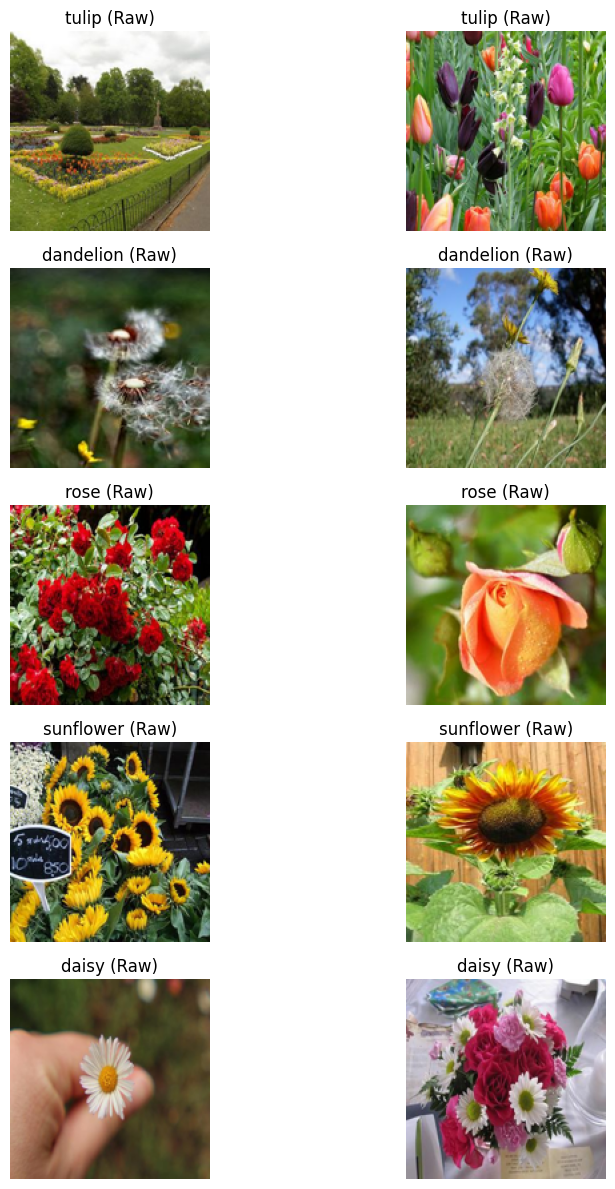

In [ ]:
fig, axes = plt.subplots(len(categories), 2, figsize=(10, 12))
for i, cat in enumerate(categories):
    cat_path = os.path.join(train_data_dir, cat)
    images = os.listdir(cat_path)
    sample_imgs = random.sample(images, 2) if len(images) >= 2 else images[:2]
    for j, img_name in enumerate(sample_imgs):
        img_path = os.path.join(cat_path, img_name)
        img = Image.open(img_path)
        img = img.resize((150, 150))
        axes[i, j].imshow(img)
        axes[i, j].set_title(f"{cat} (Raw)")
        axes[i, j].axis("off")
plt.tight_layout()
plt.show()


In [ ]:
train_dir = os.path.join(split_dataset_dir, "train")
val_dir   = os.path.join(split_dataset_dir, "val")
test_dir  = os.path.join(split_dataset_dir, "test")
img_height, img_width = 150, 150

batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen   = ImageDataGenerator(rescale=1./255)
test_datagen  = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print("Class indices:", train_generator.class_indices)

model = models.Sequential([

    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(img_height, img_width, 3)),

    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64, (3, 3), activation='relu'),

    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128, (3, 3), activation='relu'),

    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),

    layers.Dense(128, activation='relu'),

    layers.Dropout(0.5),

    layers.Dense(num_classes, activation='softmax')

])

model.summary()

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

Found 3022 images belonging to 5 classes.
Found 644 images belonging to 5 classes.
Found 654 images belonging to 5 classes.
Class indices: {'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_9 (Conv2D)                    │ (None, 148, 148, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 74, 74, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_10 (Conv2D)                   │ (None, 72, 72, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 36, 36, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 34, 34, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 17, 17, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 36992)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 128)                 │       4,735,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             645 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,828,997 (18.42 MB)

 Trainable params: 4,828,997 (18.42 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 10

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples
    epochs=epochs,
    validation_data=val_generator,
    validation_steps=val_generator.samples
    verbose=1
)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.3335 - loss: 1.4845 - val_accuracy: 0.5766 - val_loss: 1.1414
Epoch 2/10
 1/94 ━━━━━━━━━━━━━━━━━━━━ 1:59 1s/step - accuracy: 0.4688 - loss: 1.0894

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


94/94 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - accuracy: 0.4688 - loss: 1.0894 - val_accuracy: 0.5906 - val_loss: 1.1458
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.5667 - loss: 1.0963 - val_accuracy: 0.6297 - val_loss: 1.0036
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 225ms/step - accuracy: 0.5000 - loss: 1.1288 - val_accuracy: 0.6313 - val_loss: 1.0042
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 194s 2s/step - accuracy: 0.6304 - loss: 0.9318 - val_accuracy: 0.6266 - val_loss: 0.9935
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 217ms/step - accuracy: 0.5938 - loss: 0.9664 - val_accuracy: 0.6031 - val_loss: 0.9991
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.6797 - loss: 0.8369 - val_accuracy: 0.6453 - val_loss: 0.9120
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 22s 224ms/step - accuracy: 0.6562 - loss: 0.7605 - val_accuracy: 0.6641 - val_loss: 0.9172
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.7454 - loss: 0.6923 - val_accuracy: 0.6594 - val_

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 404ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 388ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 402ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 559ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 653ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 699ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step


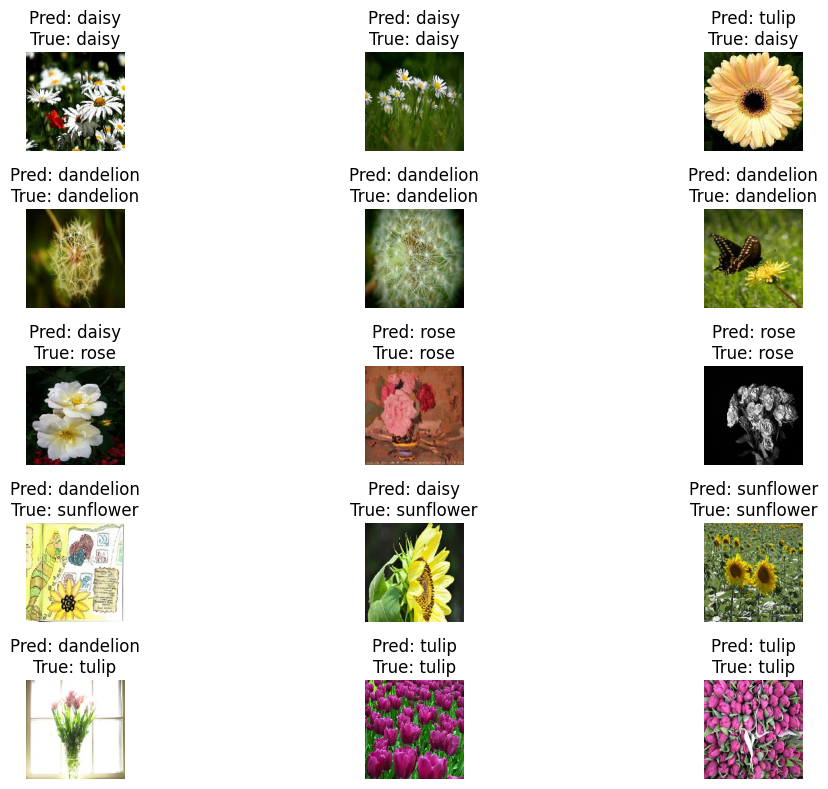

In [ ]:
from collections import defaultdict

def collect_samples_per_category(test_generator, model, num_per_class=3):
    test_generator.reset()
    class_labels = list(test_generator.class_indices.keys())
    samples_per_class = defaultdict(list)

    while any(len(samples_per_class[cls]) < num_per_class for cls in class_labels):
        X_batch, y_batch = next(test_generator)
        predictions_batch = model.predict(X_batch)
        pred_classes = np.argmax(predictions_batch, axis=1)
        true_classes = np.argmax(y_batch, axis=1)

        for i in range(len(X_batch)):
            true_label = class_labels[true_classes[i]]
            if len(samples_per_class[true_label]) < num_per_class:
                samples_per_class[true_label].append((X_batch[i], true_classes[i], pred_classes[i]))

    X_samples, true_samples, pred_samples = [], [], []
    for cls in class_labels:
        for sample in samples_per_class[cls]:
            X_samples.append(sample[0])
            true_samples.append(sample[1])
            pred_samples.append(sample[2])

    return np.array(X_samples), np.array(true_samples), np.array(pred_samples), class_labels

X_samples, true_samples, pred_samples, class_labels = collect_samples_per_category(test_generator, model, num_per_class=3)

plt.figure(figsize=(12, 8))
for i in range(len(X_samples)):
    plt.subplot(len(class_labels), 3, i + 1)
    plt.imshow(X_samples[i])
    plt.title(f"Pred: {class_labels[pred_samples[i]]}\nTrue: {class_labels[true_samples[i]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

21/21 ━━━━━━━━━━━━━━━━━━━━ 16s 712ms/step
Classification Report:
              precision    recall  f1-score   support

       daisy       0.72      0.58      0.64       116
   dandelion       0.70      0.81      0.75       159
        rose       0.68      0.50      0.57       119
   sunflower       0.78      0.75      0.76       111
       tulip       0.58      0.71      0.64       149

    accuracy                           0.68       654
   macro avg       0.69      0.67      0.67       654
weighted avg       0.68      0.68      0.67       654

Weighted Precision: 0.6845
Weighted Recall:    0.6774
Weighted F1-score:  0.6743


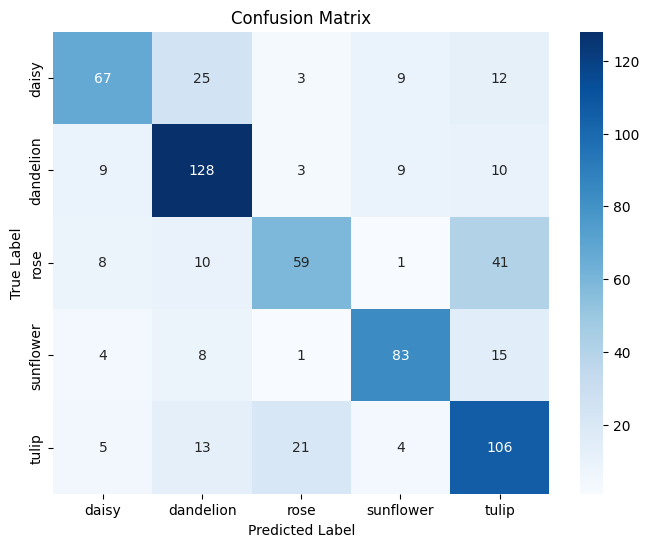

In [ ]:
test_generator.reset()
Y_pred = model.predict(test_generator, steps=test_generator.samples // batch_size + 1)
y_pred = np.argmax(Y_pred, axis=1)
y_true = test_generator.classes

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"Weighted Precision: {precision:.4f}")
print(f"Weighted Recall:    {recall:.4f}")
print(f"Weighted F1-score:  {f1:.4f}")

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model_save_path = "/content/drive/My Drive/flowers_model.h5"
model.save(model_save_path)
print(f"Model saved to: {model_save_path}")


Model saved to: /content/drive/My Drive/flowers_model.h5
